In [6]:
%matplotlib inline

from hydra import initialize, compose

import dr_gen.utils.run as ru
import dr_gen.data.load_data as du
import dr_gen.data.viz as vu
import dr_gen.train.model as mu
import dr_gen.train.loops as te

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Config & Helpers

In [3]:
with initialize(config_path="../configs/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
    )

In [4]:
generator = ru.set_deterministic(cfg.seed)

### Test Model Init

#### Test Model Initialization

#### Test Model Eval and Checkpoint

In [4]:
split_dls = du.get_dataloaders(cfg, generator)

In [5]:
num_classes = len(split_dls["train"].dataset.classes)
print(f">> CIFAR 10 has {num_classes} classes, as expected")

>> CIFAR 10 has 10 classes, as expected


**Verify that creating two models and evaling them gives the same result after restarting:**

In [6]:
model_one = mu.create_model(cfg, num_classes)
criterion = te.get_criterion(cfg)
print(
    f">> Model: {cfg.model.name} Weights: {cfg.model.weights}, Criterion: {criterion}"
)

>> Model: resnet18 Weights: None, Criterion: CrossEntropyLoss()


In [7]:
val_model_one = te.eval_model(cfg, model_one, split_dls["val"], criterion)

>> 10000| loss=tensor(2.3352)


In [8]:
model_two = mu.create_model(cfg, num_classes)
val_model_two = te.eval_model(cfg, model_two, split_dls["val"], criterion)

>> 10000| loss=tensor(2.3209)


**Verify that checkpointing, and then loading gives the expected val for both:**

In [9]:
mu.checkpoint_model(cfg, model_one, "init_model_s202_val_2.3352")
mu.checkpoint_model(cfg, model_two, "init_model_s202_val_2.3209")

>> Saved checkpoint to: /Users/daniellerothermel/drotherm/logs/dr_gen/2025-02-11/16-24-16/checkpoints/init_model_s202_val_2.3352.pt
>> Saved checkpoint to: /Users/daniellerothermel/drotherm/logs/dr_gen/2025-02-11/16-24-16/checkpoints/init_model_s202_val_2.3209.pt


In [10]:
cfg.model.load_checkpoint = "/Users/daniellerothermel/drotherm/logs/dr_gen/2025-02-11/16-12-09/checkpoints/init_model_s202_val_2.3352.pt"
model_cpt1 = mu.create_model(cfg, num_classes)
val_model_cpt1 = te.eval_model(cfg, model_cpt1, split_dls["val"], criterion)

>> Loading checkpoint: /Users/daniellerothermel/drotherm/logs/dr_gen/2025-02-11/16-12-09/checkpoints/init_model_s202_val_2.3352.pt
>> 10000| loss=tensor(2.3352)


In [11]:
cfg.model.load_checkpoint = "/Users/daniellerothermel/drotherm/logs/dr_gen/2025-02-11/16-12-09/checkpoints/init_model_s202_val_2.3209.pt"
model_cpt2 = mu.create_model(cfg, num_classes)
val_model_cpt2 = te.eval_model(cfg, model_cpt2, split_dls["val"], criterion)

>> Loading checkpoint: /Users/daniellerothermel/drotherm/logs/dr_gen/2025-02-11/16-12-09/checkpoints/init_model_s202_val_2.3209.pt
>> 10000| loss=tensor(2.3209)


### Test out Dataloader

In [12]:
split_dls = du.get_dataloaders(cfg, generator)

Label: 6, Batch Shape: torch.Size([100, 3, 32, 32]), Total DS Len: 50000


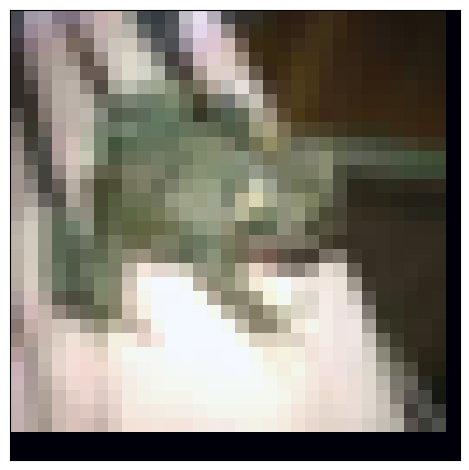

In [13]:
vu.plot_first_from_dl(split_dls["train"])

Label: 9, Batch Shape: torch.Size([10000, 3, 32, 32]), Total DS Len: 10000


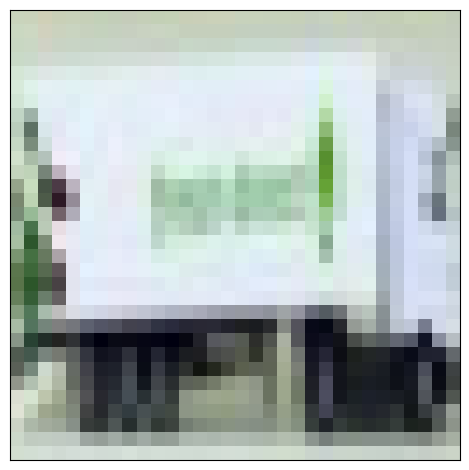

In [14]:
vu.plot_first_from_dl(split_dls["val"])

Label: 2, Batch Shape: torch.Size([10000, 3, 32, 32]), Total DS Len: 10000


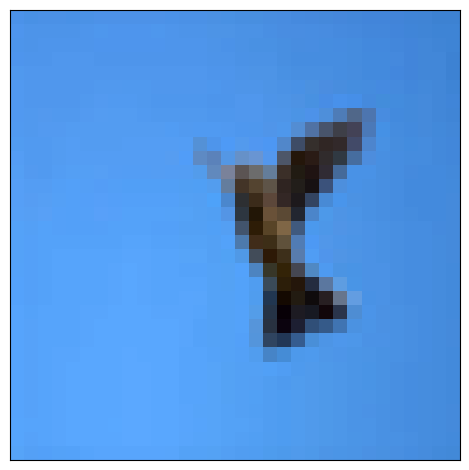

In [15]:
vu.plot_first_from_dl(split_dls["eval"])